In [2]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 1.9 MB/s eta 0:00:00a 0:00:01
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 9.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.4/253.4 kB 17.0 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 19.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 7.6 MB/s eta 0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)


In [15]:
def compute_ewma_volatility(symbol: str, db_path = "../data/futures_data.db", lambda_=0.94):
    import sqlite3
    
    span = (2 / (1 - lambda_)) - 1
    
    # Load data
    conn = sqlite3.connect(db_path)
    df = pd.read_sql(f"""
        SELECT date, close
        FROM futures_data
        WHERE symbol = '{symbol}'
        ORDER BY date
    """, conn, parse_dates=['date'])
    conn.close()

    # Clean
    df['close'] = pd.to_numeric(df['close'], errors='coerce')
    df = df.dropna()
    df = df.sort_values("date")

    # Compute returns and EWMA
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df['ewma_volatility'] = df['log_return'].ewm(span=span, adjust=False).std()
    
    return df


In [16]:
symbols = {
    "Crude Oil (CL=F)": "CL=F",
    "Gold (GC=F)": "GC=F",
    "S&P 500 E-mini (ES=F)": "ES=F"
}

dfs = {label: compute_ewma_volatility(sym) for label, sym in symbols.items()}


/Users/himanshi/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


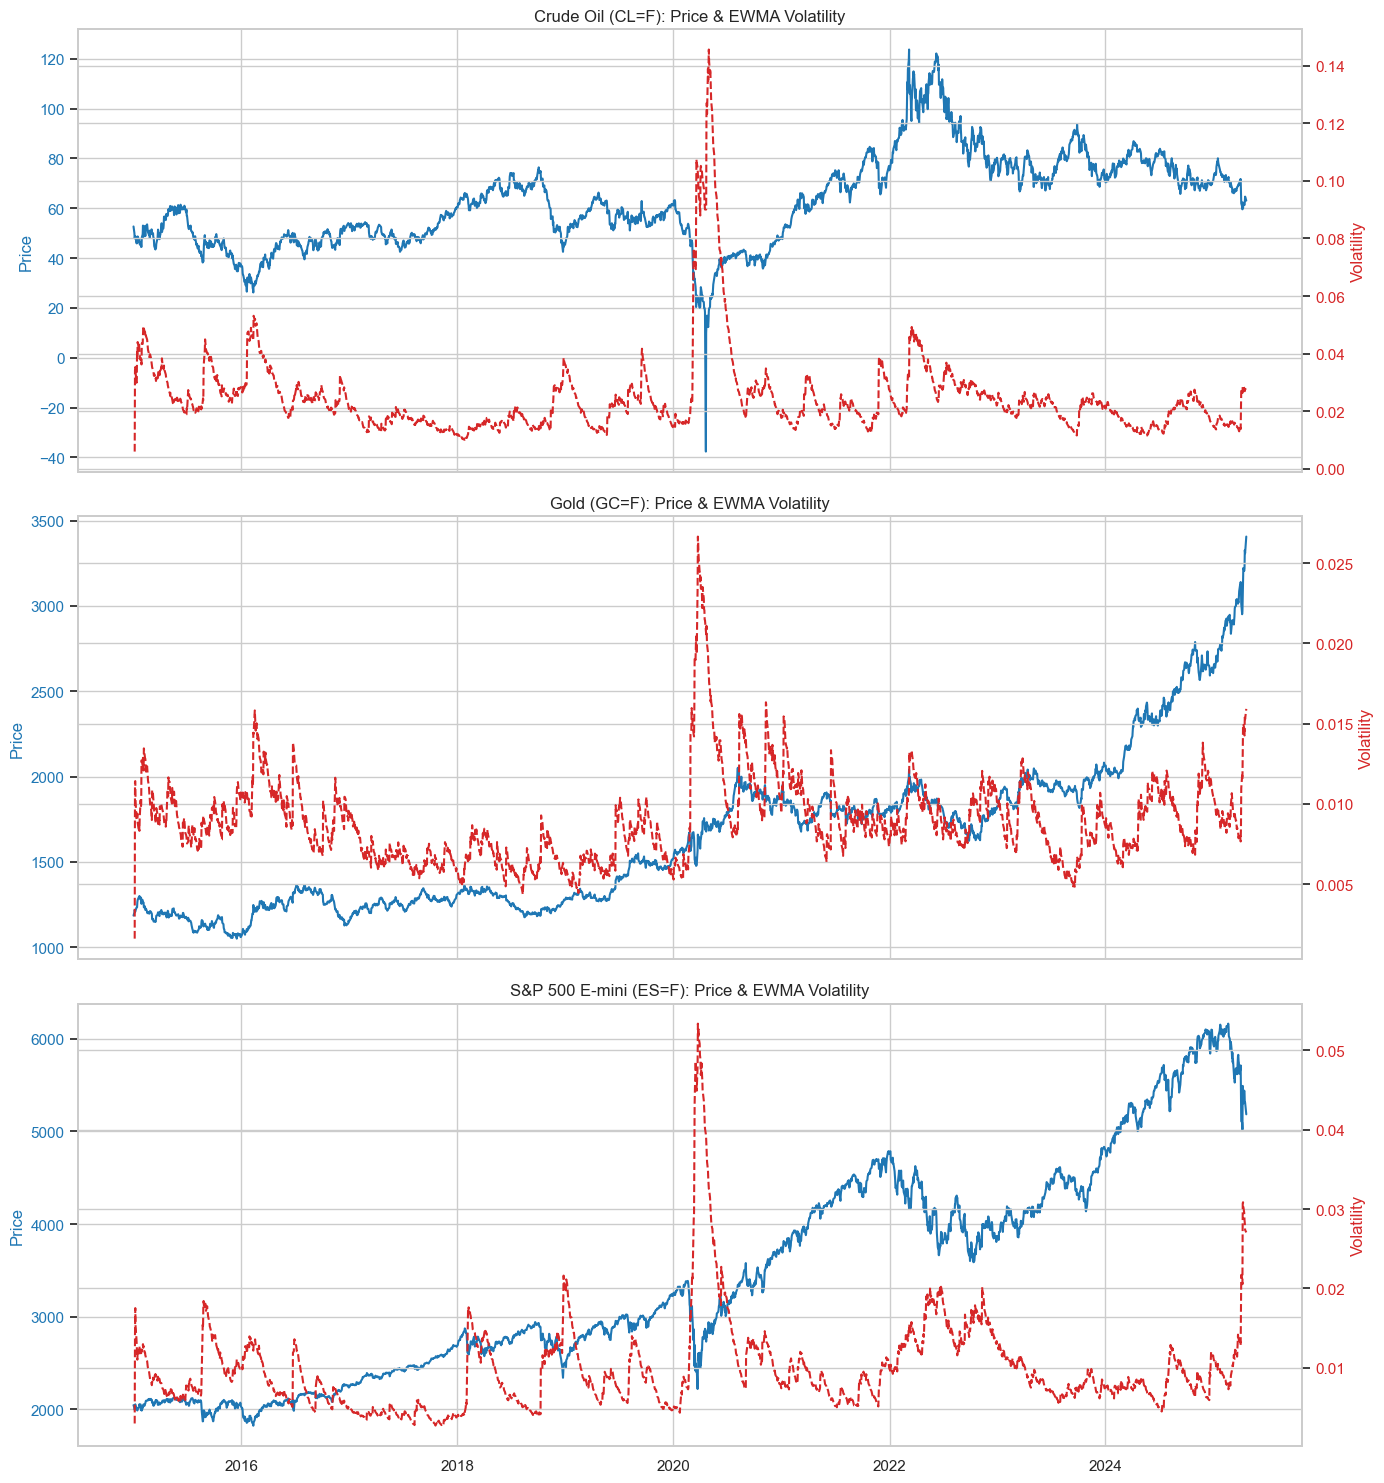

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 15), sharex=True)

for ax, (label, df) in zip(axes, dfs.items()):
    ax2 = ax.twinx()
    
    # Price
    ax.plot(df['date'], df['close'], color='tab:blue', label="Close Price")
    ax.set_ylabel("Price", color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    
    # Volatility
    ax2.plot(df['date'], df['ewma_volatility'], color='tab:red', linestyle='--', label="EWMA Volatility")
    ax2.set_ylabel("Volatility", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    ax.set_title(f"{label}: Price & EWMA Volatility")

plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [22]:
for label, df in dfs.items():
    print(f"\n📊 {label} EWMA Volatility Summary:")
    print(df['ewma_volatility'].describe().round(4))



📊 Crude Oil (CL=F) EWMA Volatility Summary:
count    2587.0000
mean        0.0250
std         0.0152
min         0.0060
25%         0.0166
50%         0.0218
75%         0.0274
max         0.1456
Name: ewma_volatility, dtype: float64

📊 Gold (GC=F) EWMA Volatility Summary:
count    2586.0000
mean        0.0089
std         0.0027
min         0.0016
25%         0.0071
50%         0.0085
75%         0.0101
max         0.0267
Name: ewma_volatility, dtype: float64

📊 S&P 500 E-mini (ES=F) EWMA Volatility Summary:
count    2588.0000
mean        0.0098
std         0.0059
min         0.0027
25%         0.0063
50%         0.0084
75%         0.0119
max         0.0534
Name: ewma_volatility, dtype: float64


In [21]:
symbols = {
    "Crude Oil (CL=F)": "CL=F",
    "Gold (GC=F)": "GC=F",
    "S&P 500 E-mini (ES=F)": "ES=F"
}

results = {}
for label, sym in symbols.items():
    df = compute_ewma_volatility(sym)
    vol_stats = df['ewma_volatility'].describe()
    threshold = vol_stats['75%']
    high_vol_periods = df[df['ewma_volatility'] > threshold]
    last_spike = high_vol_periods.sort_values(by='date', ascending=False).head(1)
    
    last_date = last_spike['date'].iloc[0].date() if not last_spike.empty else None
    last_val = round(last_spike['ewma_volatility'].iloc[0], 4) if not last_spike.empty else None
    
    print(f"\n📊 {label} EWMA Volatility Summary:")
    print(vol_stats.round(4))
    print(f"⚠️ High Volatility Days (> 75th percentile): {len(high_vol_periods)}")
    print(f"🕵️ Last major volatility spike: {last_date} — {last_val}")
    print(f"🧠 Insight: During peak uncertainty, {label} showed heightened volatility.\n"
          f"The 75th percentile volatility was {threshold:.4f}, with the latest major spike on {last_date} reaching {last_val}.")



📊 Crude Oil (CL=F) EWMA Volatility Summary:
count    2587.0000
mean        0.0250
std         0.0152
min         0.0060
25%         0.0166
50%         0.0218
75%         0.0274
max         0.1456
Name: ewma_volatility, dtype: float64
⚠️ High Volatility Days (> 75th percentile): 647
🕵️ Last major volatility spike: 2025-04-21 — 0.0275
🧠 Insight: During peak uncertainty, Crude Oil (CL=F) showed heightened volatility.
The 75th percentile volatility was 0.0274, with the latest major spike on 2025-04-21 reaching 0.0275.

📊 Gold (GC=F) EWMA Volatility Summary:
count    2586.0000
mean        0.0089
std         0.0027
min         0.0016
25%         0.0071
50%         0.0085
75%         0.0101
max         0.0267
Name: ewma_volatility, dtype: float64
⚠️ High Volatility Days (> 75th percentile): 647
🕵️ Last major volatility spike: 2025-04-21 — 0.0159
🧠 Insight: During peak uncertainty, Gold (GC=F) showed heightened volatility.
The 75th percentile volatility was 0.0101, with the latest major spike

/Users/himanshi/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GARCH(1,1) Volatility Modeling
📌 Why GARCH?
EWMA assumes constant decay; GARCH learns volatility clustering from data.

More accurate for risk forecasting, VaR, and stress testing.



In [ ]:
pip install arch


/Users/himanshi/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


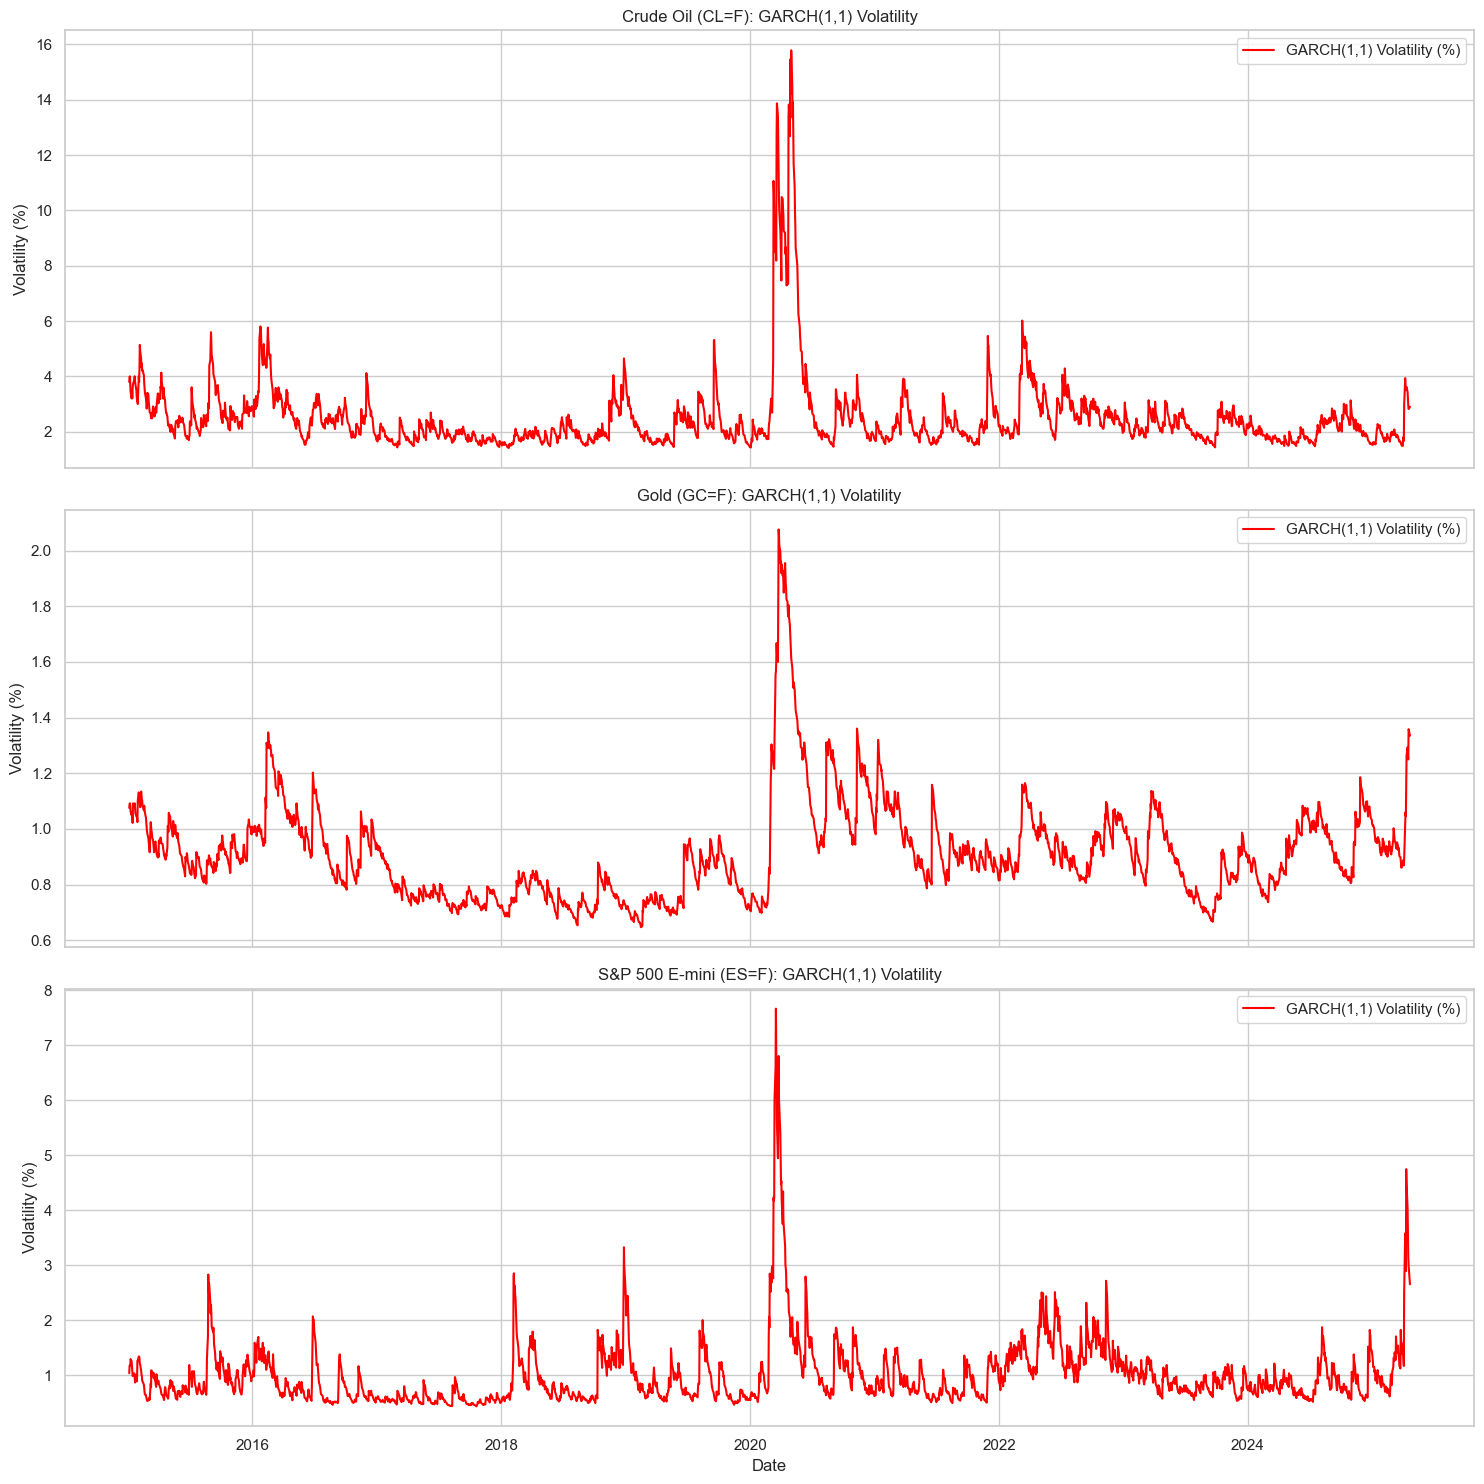

In [26]:
from arch import arch_model
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

def compute_garch(symbol, db_path="../data/futures_data.db"):
    # Load data
    conn = sqlite3.connect(db_path)
    df = pd.read_sql(f"""
        SELECT date, close FROM futures_data
        WHERE symbol = '{symbol}' ORDER BY date
    """, conn, parse_dates=['date'])
    conn.close()

    # Prepare data
    df['close'] = pd.to_numeric(df['close'], errors='coerce')
    df.dropna(inplace=True)
    df.sort_values('date', inplace=True)
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df.dropna(inplace=True)

    # Fit GARCH(1,1)
    returns = df['log_return'] * 100  # percent
    model = arch_model(returns, vol='Garch', p=1, q=1)
    garch_fit = model.fit(disp='off')
    df['garch_volatility'] = garch_fit.conditional_volatility

    return df

# Define assets
symbols = {
    "Crude Oil (CL=F)": "CL=F",
    "Gold (GC=F)": "GC=F",
    "S&P 500 E-mini (ES=F)": "ES=F"
}

# Compute GARCH for each asset
dfs = {label: compute_garch(sym) for label, sym in symbols.items()}

# Plot GARCH Volatility
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

for ax, (label, df) in zip(axs, dfs.items()):
    ax.plot(df['date'], df['garch_volatility'], color='red', label='GARCH(1,1) Volatility (%)')
    ax.set_title(f"{label}: GARCH(1,1) Volatility")
    ax.set_ylabel("Volatility (%)")
    ax.legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()


### 💡 Insights:

#### 🛢️ **Crude Oil (CL=F)**
- **Spiky behavior**, especially during 2020 oil crash.
- GARCH shows **high persistence**: once volatility spikes, it stays high longer.
- **Use case**: monitor risk in energy markets or during geopolitical shocks.

#### 🪙 **Gold (GC=F)**
- More **stable**, acts as a **safe haven** asset.
- Volatility spikes usually coincide with financial crises or interest rate uncertainty.
- **Use case**: hedge market downturns, inflation protection.

#### 📈 **S&P 500 E-mini (ES=F)**
- GARCH captures event-driven spikes (e.g., COVID crash, inflation panic).
- EWMA lags behind in response time, GARCH predicts lingering risk better.
- **Use case**: managing index exposure, forecasting market risk in portfolios.


## 📉 What is Value at Risk (VaR)?

> **VaR answers**: *“What is the worst expected loss over a given time horizon at a certain confidence level?”*

### Example:
> “At 95% confidence, we expect not to lose more than **$X** in a day.”

## ✅ We’ll Calculate:
- **1-day VaR** at 95% and 99% confidence
- Based on **GARCH(1,1) volatility**
- For all 3 futures: CL=F, GC=F, ES=F

## 📌 Assumptions:
- Returns are **normally distributed**
- GARCH volatility is in **percent daily terms**
- Portfolio position = **$1,000,000** in each asset (adjustable)



📊 Processing: Crude Oil (CL=F)


/Users/himanshi/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


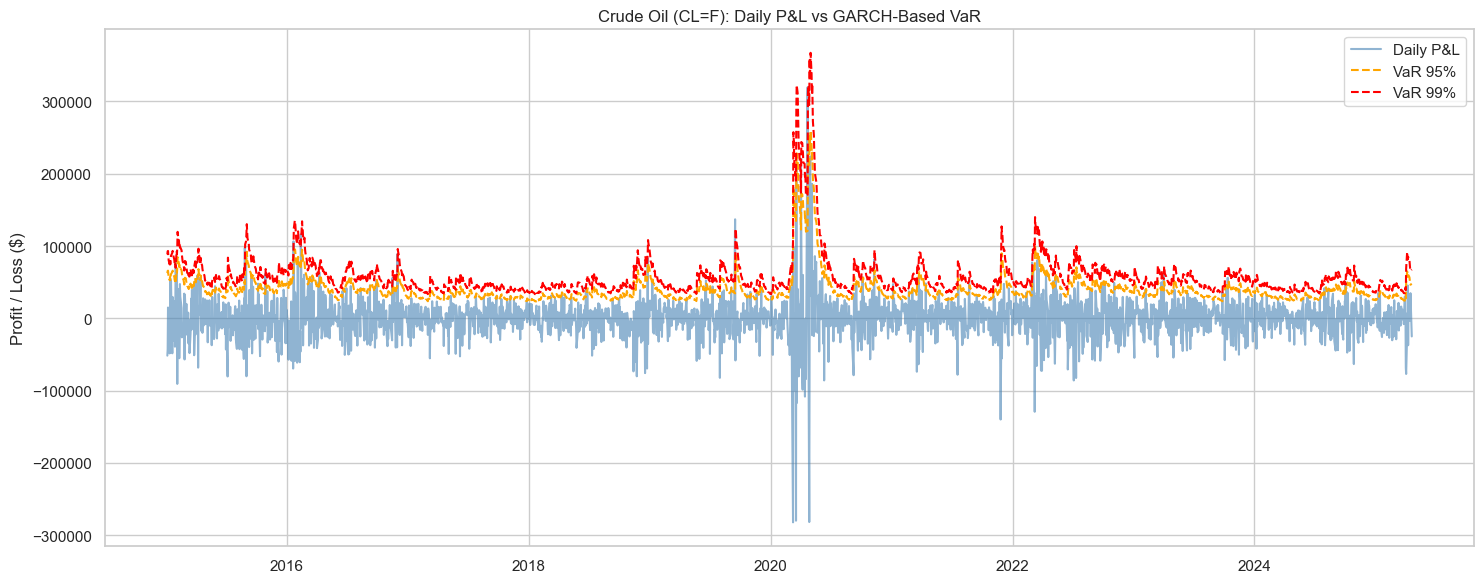

🔎 Backtest Summary for Crude Oil (CL=F):
  VaR_95 → Breaches: 141 | Expected: 129 | Breach Rate: 5.45%
  VaR_99 → Breaches: 38 | Expected: 25 | Breach Rate: 1.47%

📊 Processing: Gold (GC=F)


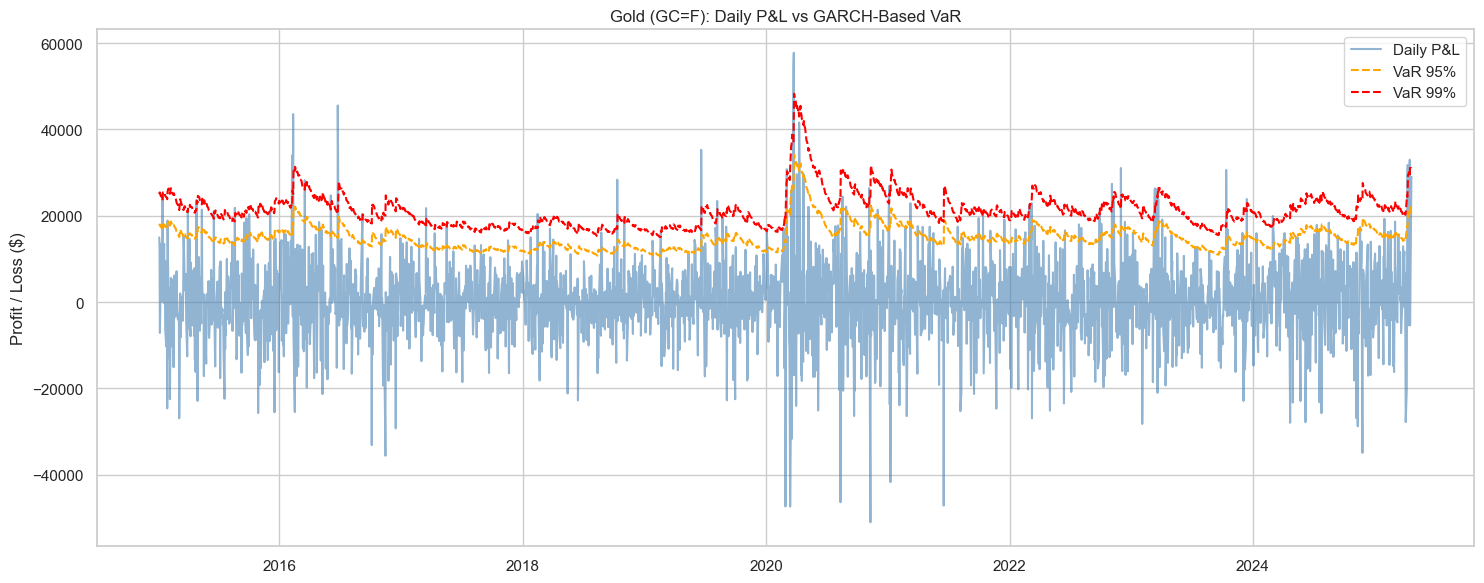

🔎 Backtest Summary for Gold (GC=F):
  VaR_95 → Breaches: 123 | Expected: 129 | Breach Rate: 4.75%
  VaR_99 → Breaches: 48 | Expected: 25 | Breach Rate: 1.86%

📊 Processing: S&P 500 E-mini (ES=F)


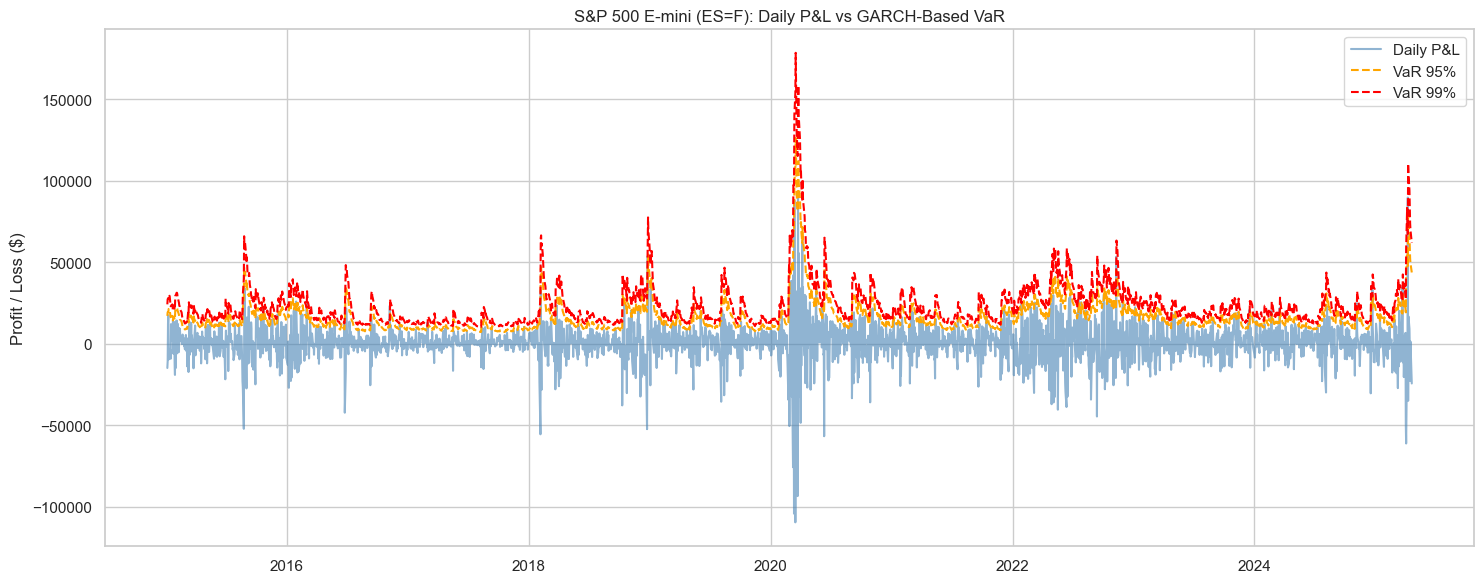

🔎 Backtest Summary for S&P 500 E-mini (ES=F):
  VaR_95 → Breaches: 122 | Expected: 129 | Breach Rate: 4.71%
  VaR_99 → Breaches: 49 | Expected: 25 | Breach Rate: 1.89%


,VaR_95,VaR_99
Crude Oil (CL=F),"{'breaches': 141, 'expected_breaches': 129, 'a...","{'breaches': 38, 'expected_breaches': 25, 'act..."
Gold (GC=F),"{'breaches': 123, 'expected_breaches': 129, 'a...","{'breaches': 48, 'expected_breaches': 25, 'act..."
S&P 500 E-mini (ES=F),"{'breaches': 122, 'expected_breaches': 129, 'a...","{'breaches': 49, 'expected_breaches': 25, 'act..."


In [34]:
from arch import arch_model
import pandas as pd
import numpy as np
import sqlite3
from scipy.stats import norm
import matplotlib.pyplot as plt

def compute_garch(symbol, db_path="../data/futures_data.db"):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql(f"""
        SELECT date, close FROM futures_data
        WHERE symbol = '{symbol}' ORDER BY date
    """, conn, parse_dates=['date'])
    conn.close()

    df['close'] = pd.to_numeric(df['close'], errors='coerce')
    df.dropna(inplace=True)
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df.dropna(inplace=True)

    model = arch_model(df['log_return'] * 100, vol='Garch', p=1, q=1)
    fit = model.fit(disp='off')
    df['garch_volatility'] = fit.conditional_volatility
    return df

def compute_var_backtest(df, position_size=1_000_000):
    df = df.copy()
    for alpha in [0.95, 0.99]:
        z = norm.ppf(1 - alpha)
        df[f'VaR_{int(alpha*100)}'] = -z * df['garch_volatility'] / 100 * position_size
    df['pnl'] = df['log_return'] * position_size
    results = {}
    for alpha in [0.95, 0.99]:
        col = f'VaR_{int(alpha*100)}'
        df[f'breach_{col}'] = df['pnl'] < -df[col]
        breaches = df[f'breach_{col}'].sum()
        expected = int(len(df) * (1 - alpha))
        results[col] = {
            "breaches": breaches,
            "expected_breaches": expected,
            "actual_breach_rate": round(breaches / len(df), 4)
        }
    return df, results

# Run for all 3 assets
symbols = {
    "Crude Oil (CL=F)": "CL=F",
    "Gold (GC=F)": "GC=F",
    "S&P 500 E-mini (ES=F)": "ES=F"
}

dfs = {}
dfs_var = {}
backtest_results = {}

for label, symbol in symbols.items():
    print(f"\n📊 Processing: {label}")
    df = compute_garch(symbol)
    dfs[label] = df
    df_var, results = compute_var_backtest(df)
    dfs_var[label] = df_var
    backtest_results[label] = results

    # Plot for each asset
    plt.figure(figsize=(15, 6))
    plt.plot(df_var['date'], df_var['pnl'], label='Daily P&L', alpha=0.6, color='steelblue')
    plt.plot(df_var['date'], df_var['VaR_95'], label='VaR 95%', linestyle='--', color='orange')
    plt.plot(df_var['date'], df_var['VaR_99'], label='VaR 99%', linestyle='--', color='red')
    plt.title(f"{label}: Daily P&L vs GARCH-Based VaR")
    plt.ylabel("Profit / Loss ($)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print backtest result
    print(f"🔎 Backtest Summary for {label}:")
    for level, stats in results.items():
        print(f"  {level} → Breaches: {stats['breaches']} | Expected: {stats['expected_breaches']} | Breach Rate: {stats['actual_breach_rate'] * 100:.2f}%")

# Optional: full summary table
summary_table = pd.DataFrame(backtest_results).T
summary_table



📊 Processing: Crude Oil (CL=F)


/Users/himanshi/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


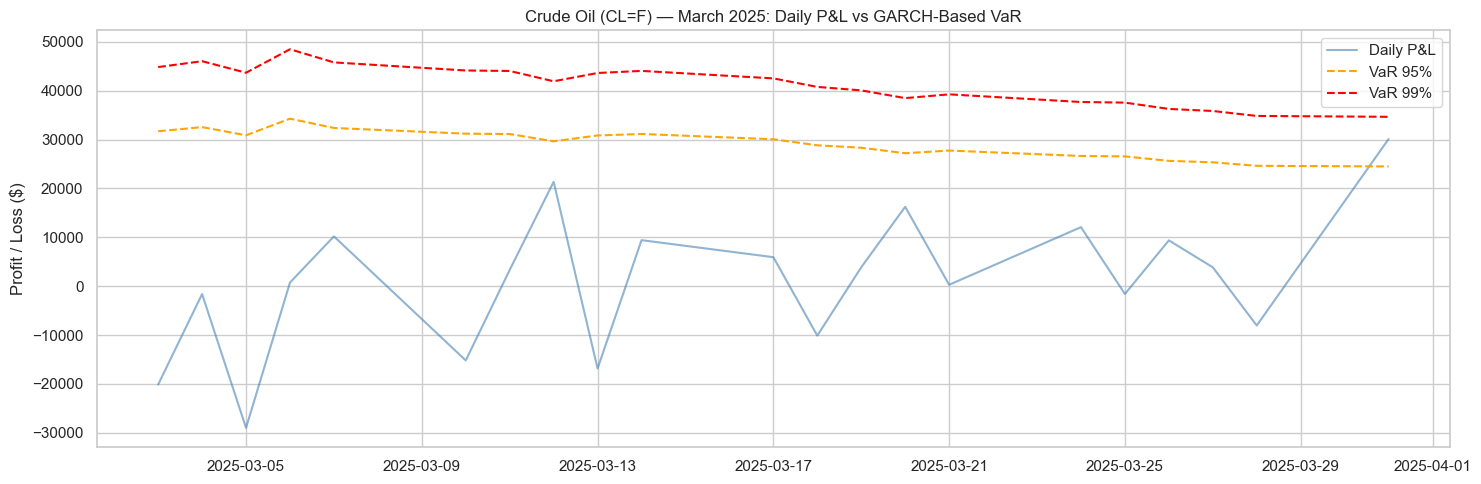

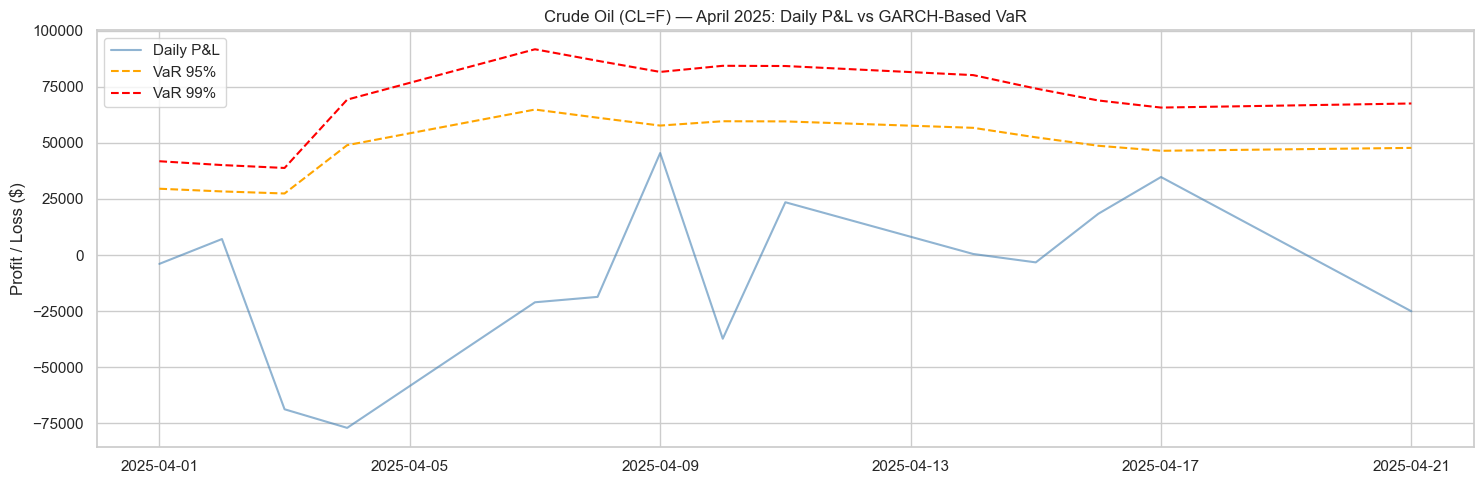

🔎 Backtest Summary for Crude Oil (CL=F):
  VaR_95 → Breaches: 141 | Expected: 129 | Breach Rate: 5.45%
  VaR_99 → Breaches: 38 | Expected: 25 | Breach Rate: 1.47%

📊 Processing: Gold (GC=F)


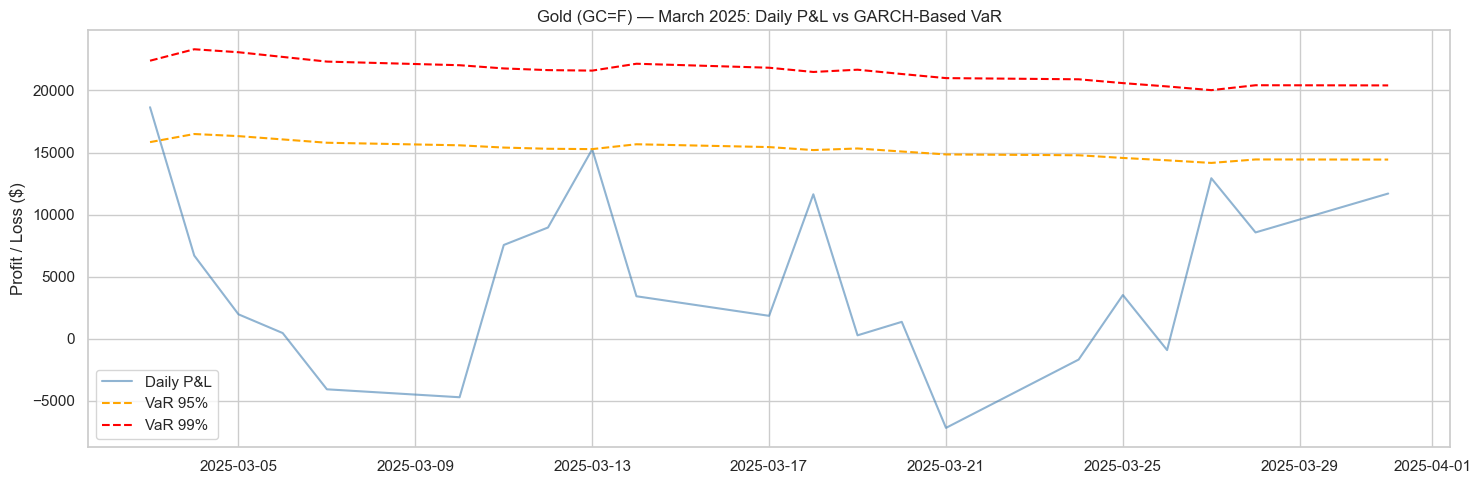

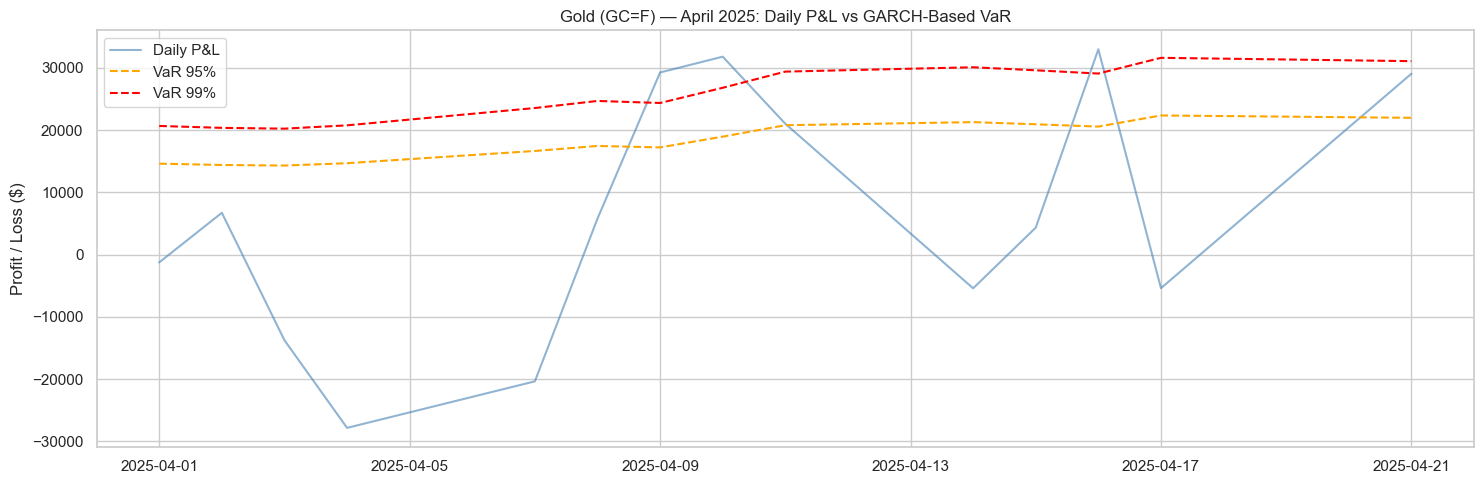

🔎 Backtest Summary for Gold (GC=F):
  VaR_95 → Breaches: 123 | Expected: 129 | Breach Rate: 4.75%
  VaR_99 → Breaches: 48 | Expected: 25 | Breach Rate: 1.86%

📊 Processing: S&P 500 E-mini (ES=F)


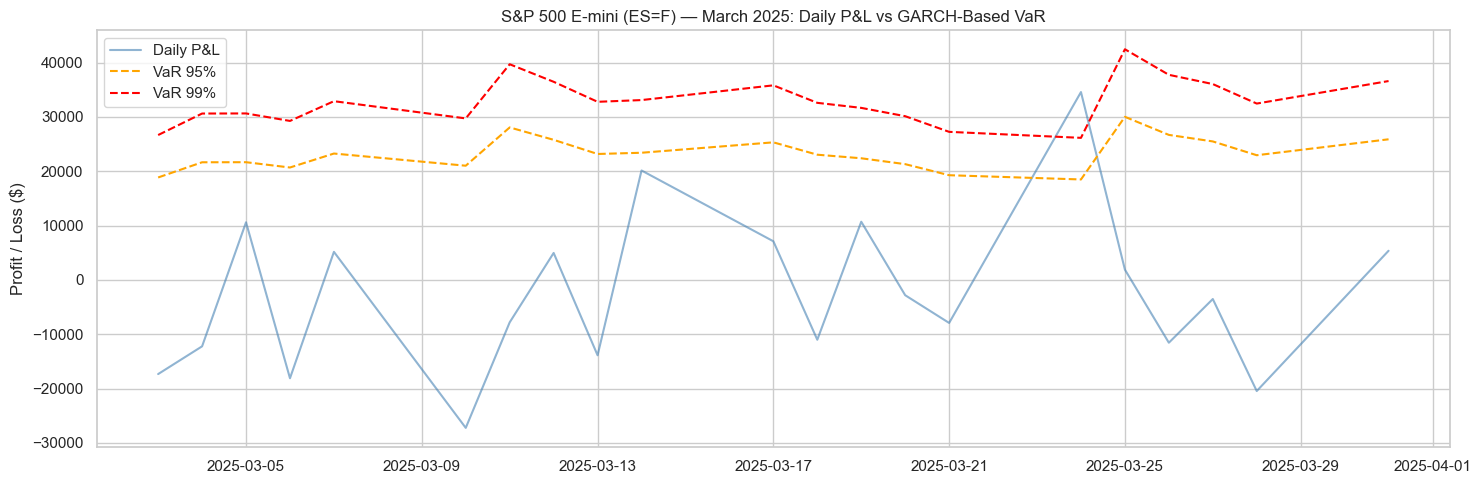

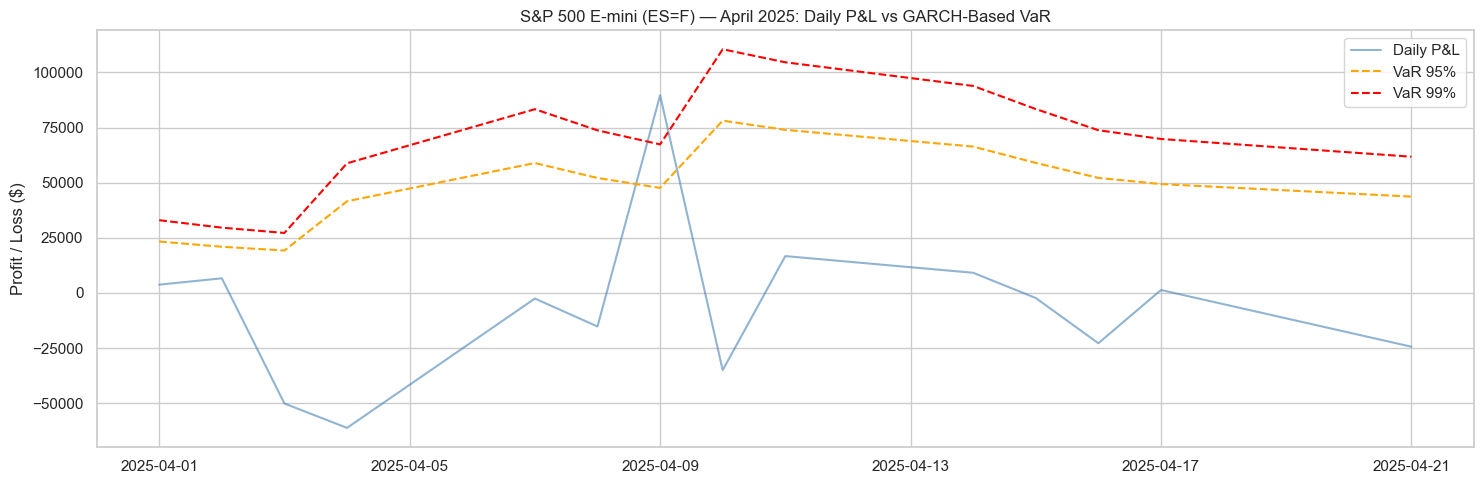

🔎 Backtest Summary for S&P 500 E-mini (ES=F):
  VaR_95 → Breaches: 122 | Expected: 129 | Breach Rate: 4.71%
  VaR_99 → Breaches: 49 | Expected: 25 | Breach Rate: 1.89%


,VaR_95,VaR_99
Crude Oil (CL=F),"{'breaches': 141, 'expected_breaches': 129, 'a...","{'breaches': 38, 'expected_breaches': 25, 'act..."
Gold (GC=F),"{'breaches': 123, 'expected_breaches': 129, 'a...","{'breaches': 48, 'expected_breaches': 25, 'act..."
S&P 500 E-mini (ES=F),"{'breaches': 122, 'expected_breaches': 129, 'a...","{'breaches': 49, 'expected_breaches': 25, 'act..."


In [35]:
from arch import arch_model
import pandas as pd
import numpy as np
import sqlite3
from scipy.stats import norm
import matplotlib.pyplot as plt

# GARCH modeling function
def compute_garch(symbol, db_path="../data/futures_data.db"):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql(f"""
        SELECT date, close FROM futures_data
        WHERE symbol = '{symbol}' ORDER BY date
    """, conn, parse_dates=['date'])
    conn.close()

    df['close'] = pd.to_numeric(df['close'], errors='coerce')
    df.dropna(inplace=True)
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df.dropna(inplace=True)

    model = arch_model(df['log_return'] * 100, vol='Garch', p=1, q=1)
    fit = model.fit(disp='off')
    df['garch_volatility'] = fit.conditional_volatility
    return df

# Compute VaR and backtest results
def compute_var_backtest(df, position_size=1_000_000):
    df = df.copy()
    for alpha in [0.95, 0.99]:
        z = norm.ppf(1 - alpha)
        df[f'VaR_{int(alpha*100)}'] = -z * df['garch_volatility'] / 100 * position_size
    df['pnl'] = df['log_return'] * position_size
    results = {}
    for alpha in [0.95, 0.99]:
        col = f'VaR_{int(alpha*100)}'
        df[f'breach_{col}'] = df['pnl'] < -df[col]
        breaches = df[f'breach_{col}'].sum()
        expected = int(len(df) * (1 - alpha))
        results[col] = {
            "breaches": breaches,
            "expected_breaches": expected,
            "actual_breach_rate": round(breaches / len(df), 4)
        }
    return df, results

# Filter to a specific year and month
def filter_to_month(df, year, month):
    return df[(df['date'].dt.year == year) & (df['date'].dt.month == month)].copy()

# Process all 3 assets
symbols = {
    "Crude Oil (CL=F)": "CL=F",
    "Gold (GC=F)": "GC=F",
    "S&P 500 E-mini (ES=F)": "ES=F"
}

dfs = {}
dfs_var = {}
backtest_results = {}

for label, symbol in symbols.items():
    print(f"\n📊 Processing: {label}")
    df = compute_garch(symbol)
    dfs[label] = df
    df_var, results = compute_var_backtest(df)
    dfs_var[label] = df_var
    backtest_results[label] = results

    # Filter months
    df_march = filter_to_month(df_var, 2025, 3)
    df_april = filter_to_month(df_var, 2025, 4)

    for period_label, df_month in zip(["March 2025", "April 2025"], [df_march, df_april]):
        if not df_month.empty:
            plt.figure(figsize=(15, 5))
            plt.plot(df_month['date'], df_month['pnl'], label='Daily P&L', alpha=0.6, color='steelblue')
            plt.plot(df_month['date'], df_month['VaR_95'], label='VaR 95%', linestyle='--', color='orange')
            plt.plot(df_month['date'], df_month['VaR_99'], label='VaR 99%', linestyle='--', color='red')
            plt.title(f"{label} — {period_label}: Daily P&L vs GARCH-Based VaR")
            plt.ylabel("Profit / Loss ($)")
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print(f"⚠️ No data available for {label} — {period_label}")

    # Backtest summary
    print(f"🔎 Backtest Summary for {label}:")
    for level, stats in results.items():
        print(f"  {level} → Breaches: {stats['breaches']} | Expected: {stats['expected_breaches']} | Breach Rate: {stats['actual_breach_rate'] * 100:.2f}%")

# Optional: full summary table
summary_table = pd.DataFrame(backtest_results).T
summary_table
